# Model comparison

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise
import numpy as np
import optuna, sklearn, sklearn.datasets
from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression

Using Python-MIP package version 1.7.2


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

## Parte 1: Data treatment

In [3]:
mydata= pd.read_csv("Datasets/german_credit_data.csv")

Dados de pedidos de crédito. É um dos datasets mais utilizados para tutoriais em Fairness, como na biblioteca [$aif360$](https://github.com/IBM/AIF360/blob/master/examples/README.md). Dataset original disponível em [aqui](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)), mas eu utilizei [este](https://www.kaggle.com/kabure/german-credit-data-with-risk), por estar em formato csv com os headers, embora omita informações do dataset original.

Originalmente possui 1000 dados, mas com vários valores NaN, ficando com 522 dados após remoção de dados com informações faltantes.

In [4]:
mydata.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
mydata = mydata.drop(['Unnamed: 0', 'Purpose'], axis=1)

In [6]:
mydata = mydata.dropna()

In [7]:
mapping_Sex = {'male': 0, 'female': 1}
mapping_Housing = {'free': 1, 'rent': 2, 'own': 3}
mapping_Savings = {'little': 1, 'moderate': 2, 'quite rich': 3, 'rich': 4}
mapping_Checking = {'little': 1, 'moderate': 2, 'rich': 3}
mapping_Risk = {"bad": -1, "good": 1}

numerical_data = mydata.replace({'Sex': mapping_Sex, 'Housing': mapping_Housing, 'Saving accounts': mapping_Savings,
                'Checking account':mapping_Checking, 'Risk': mapping_Risk})

In [8]:
X = numerical_data.drop(['Risk'], axis=1)

In [9]:
X.shape

(522, 8)

In [10]:
y = numerical_data['Risk']

In [11]:
# 395, 808
random_seed = np.random.randint(0, 1000)
random_seed

756

In [12]:
random_seed2 = np.random.randint(0, 1000)
random_seed2

261

In [13]:
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=200, random_state = random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=100, random_state = random_seed2)

In [14]:
def calc_reweight(X, y):
    W = {}
    W[0] = {}
    W[1] = {}

    D = len(X)
    len_men = X.groupby('Sex').count()['Age'][0]
    len_women = X.groupby('Sex').count()['Age'][1]
    len_neg = sum(y==-1)
    len_pos = sum(y==1)
    len_men_pos = len(X[(X.Sex == 0) & (y == 1)])
    len_men_neg = len(X[(X.Sex == 0) & (y == -1)])
    len_women_pos = len(X[(X.Sex == 1) & (y == 1)])
    len_women_neg = len(X[(X.Sex == 1) & (y == -1)])

    W[0][1] = (len_men*len_pos)/(D*len_men_pos)
    W[0][-1] = (len_men*len_neg)/(D*len_men_neg)

    W[1][1] = (len_women*len_pos)/(D*len_women_pos)
    W[1][-1] = (len_women*len_neg)/(D*len_women_neg)
    
    sample_weight = []
    for i in range(X.shape[0]):
        sample_weight.append(W[X.iloc[i]['Sex']][y.iloc[i]])

    return sample_weight

In [15]:
sample_weight = calc_reweight(X_train, y_train)

## Parte 3: Comparando os modelos

In [16]:
optimize_metrics = {'accuracy': {'metrics': ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation'],
                'LogReg': [],
                'RegEqual': [],
                'RegDemo': [],
                'RegRewe': [],
                'RegMoo': []},
                'equal_opportunity': {'metrics': ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation'],
                'LogReg': [],
                'RegEqual': [],
                'RegDemo': [],
                'RegRewe': [],
                'RegMoo': []},
                'p_percent': {'metrics': ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation'],
                'LogReg': [],
                'RegEqual': [],
                'RegDemo': [],
                'RegRewe': [],
                'RegMoo': []},
                'c_variation': {'metrics': ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation'],
                'LogReg': [],
                'RegEqual': [],
                'RegDemo': [],
                'RegRewe': [],
                'RegMoo': []}}

In [17]:
metrics = ['accuracy', 'equal_opportunity', 'p_percent', 'c_variation']

In [18]:
methods = ['LogReg', 'RegEqual', 'RegDemo', 'RegRewe', 'RegMoo']
index = [sum([[method]*len(metrics) for method in methods],[]),
        sum([metrics for method in methods],[])]
results_test = pd.DataFrame(index=index, columns=metrics)
results_val = pd.DataFrame(index=index, columns=metrics)

In [19]:
# RegLog

for metric in metrics:
    reg_log = FindCLogisticRegression(X_train, y_train, X_val, y_val, metric=metric).tune()
    # RegMoo
    print('Metric: ', metric)
    print('  Train: ')
    print('    Acc: ', reg_log.score(X_val, y_val))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_log, X_val, y_val))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_log, X_val))
    print('    CVar: ', coefficient_of_variation(reg_log, X_val, y_val))
    print('  Test: ')
    print('    Acc: ', reg_log.score(X_test, y_test))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_log, X_test, y_test))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_log, X_test))
    print('    CVar: ', coefficient_of_variation(reg_log, X_test, y_test))
    print('------------------------------------------------------')
    optimize_metrics[metric]['LogReg'] = [reg_log.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_log, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_log, X_test),
                            coefficient_of_variation(reg_log, X_test, y_test)]
    results_test.loc[('LogReg',metric),:] = [reg_log.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_log, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_log, X_test),
                            coefficient_of_variation(reg_log, X_test, y_test)]

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_

Metric:  accuracy
  Train: 
    Acc:  0.62
    Equal:  0.9264705882352942
    Parid:  0.9503105590062111
    CVar:  0.6675171498853223
  Test: 
    Acc:  0.595
    Equal:  0.8691358024691358
    Parid:  0.8382126348228043
    CVar:  0.7070763442966883
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_

Metric:  equal_opportunity
  Train: 
    Acc:  0.58
    Equal:  0.9965397923875433
    Parid:  0.9784946236559141
    CVar:  0.5603693789193424
  Test: 
    Acc:  0.615
    Equal:  0.9803240740740741
    Parid:  0.9417613636363636
    CVar:  0.5532685888252812
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_

Metric:  p_percent
  Train: 
    Acc:  0.54
    Equal:  0.9411764705882353
    Parid:  0.98989898989899
    CVar:  0.5303709967257113
  Test: 
    Acc:  0.6
    Equal:  0.9818181818181819
    Parid:  0.967860422405877
    CVar:  0.5181032733831737
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


Metric:  c_variation
  Train: 
    Acc:  0.53
    Equal:  0.9411764705882353
    Parid:  0.9753694581280787
    CVar:  0.5280530665357449
  Test: 
    Acc:  0.59
    Equal:  0.9818181818181819
    Parid:  0.9834710743801653
    CVar:  0.5166850178697981
------------------------------------------------------


In [20]:
# RegEqual

for metric in metrics:
    reg_equal = FindCCLogisticRegression(X_train, y_train, X_val, y_val, metric=metric, base_model='equal').tune()
    print('Metric: ', metric)
    print('  Train: ')
    print('    Acc: ', reg_equal.score(X_val, y_val))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_equal, X_val, y_val))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_equal, X_val))
    print('    CVar: ', coefficient_of_variation(reg_equal, X_val, y_val))
    print('  Test: ')
    print('    Acc: ', reg_equal.score(X_test, y_test))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_equal, X_test, y_test))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_equal, X_test))
    print('    CVar: ', coefficient_of_variation(reg_equal, X_test, y_test))
    print('------------------------------------------------------')
    optimize_metrics[metric]['RegEqual'] = [reg_equal.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_equal, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_log, X_test),
                            coefficient_of_variation(reg_equal, X_test, y_test)]
    results_test.loc[('RegEqual',metric),:] = [reg_equal.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_equal, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_log, X_test),
                            coefficient_of_variation(reg_equal, X_test, y_test)]

Metric:  accuracy
  Train: 
    Acc:  0.65
    Equal:  0.9965397923875433
    Parid:  0.96
    CVar:  0.5653071210389
  Test: 
    Acc:  0.63
    Equal:  0.9593787335722819
    Parid:  0.9272727272727274
    CVar:  0.6069635382866695
------------------------------------------------------
Metric:  equal_opportunity
  Train: 
    Acc:  0.57
    Equal:  0.9965397923875433
    Parid:  0.9841269841269841
    CVar:  0.5588591165708311
  Test: 
    Acc:  0.615
    Equal:  0.9930555555555555
    Parid:  0.9578598484848485
    CVar:  0.5422669329486737
------------------------------------------------------
Metric:  p_percent
  Train: 
    Acc:  0.59
    Equal:  0.9342560553633218
    Parid:  0.9942857142857143
    CVar:  0.6048384057874898
  Test: 
    Acc:  0.605
    Equal:  0.9293981481481481
    Parid:  0.9389051808406648
    CVar:  0.5955112648505556
------------------------------------------------------
Metric:  c_variation
  Train: 
    Acc:  0.61
    Equal:  0.9965397923875433
    Parid:

In [21]:
# RegDemo

for metric in metrics:
    reg_demo = FindCCLogisticRegression(X_train, y_train, X_val, y_val, metric=metric, base_model='demographic').tune()
    print('Metric: ', metric)
    print('  Train: ')
    print('    Acc: ', reg_demo.score(X_val, y_val))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_demo, X_val, y_val))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_demo, X_val))
    print('    CVar: ', coefficient_of_variation(reg_demo, X_val, y_val))
    print('  Test: ')
    print('    Acc: ', reg_demo.score(X_test, y_test))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_demo, X_test, y_test))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_demo, X_test))
    print('    CVar: ', coefficient_of_variation(reg_demo, X_test, y_test))
    print('------------------------------------------------------')
    optimize_metrics[metric]['RegDemo'] = [reg_demo.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_demo, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_demo, X_test),
                            coefficient_of_variation(reg_demo, X_test, y_test)]
    results_test.loc[('RegDemo',metric),:] = [reg_demo.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_demo, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_demo, X_test),
                            coefficient_of_variation(reg_demo, X_test, y_test)]

Metric:  accuracy
  Train: 
    Acc:  0.65
    Equal:  0.9094650205761318
    Parid:  0.9924812030075189
    CVar:  0.7406041050293548
  Test: 
    Acc:  0.65
    Equal:  0.9657064471879285
    Parid:  0.9086357947434293
    CVar:  0.7314892552951442
------------------------------------------------------
Metric:  equal_opportunity
  Train: 
    Acc:  0.52
    Equal:  1.0
    Parid:  1.0
    CVar:  0.4773924792609644
  Test: 
    Acc:  0.57
    Equal:  1.0
    Parid:  1.0
    CVar:  0.4896103794185822
------------------------------------------------------
Metric:  p_percent
  Train: 
    Acc:  0.52
    Equal:  1.0
    Parid:  1.0
    CVar:  0.4773924792609644
  Test: 
    Acc:  0.57
    Equal:  1.0
    Parid:  1.0
    CVar:  0.4896103794185822
------------------------------------------------------
Metric:  c_variation
  Train: 
    Acc:  0.52
    Equal:  1.0
    Parid:  1.0
    CVar:  0.4773924792609644
  Test: 
    Acc:  0.57
    Equal:  1.0
    Parid:  1.0
    CVar:  0.489610379418582

In [22]:
# RegRewe

for metric in metrics:
    reg_rewe = FindCLogisticRegression(X_train, y_train, X_val, y_val, metric=metric, sample_weight=sample_weight).tune()
    print('Metric: ', metric)
    print('  Train: ')
    print('    Acc: ', reg_rewe.score(X_val, y_val))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_rewe, X_val, y_val))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_rewe, X_val))
    print('    CVar: ', coefficient_of_variation(reg_rewe, X_val, y_val))
    print('  Test: ')
    print('    Acc: ', reg_rewe.score(X_test, y_test))
    print('    Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_rewe, X_test, y_test))
    print('    Parid: ', p_percent_score(sensitive_column="Sex")(reg_rewe, X_test))
    print('    CVar: ', coefficient_of_variation(reg_rewe, X_test, y_test))
    print('------------------------------------------------------')
    optimize_metrics[metric]['RegRewe'] = [reg_rewe.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_rewe, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_rewe, X_test),
                            coefficient_of_variation(reg_rewe, X_test, y_test)]
    results_test.loc[('RegRewe',metric),:] = [reg_rewe.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_rewe, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_rewe, X_test),
                            coefficient_of_variation(reg_rewe, X_test, y_test)]

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


Metric:  accuracy
  Train: 
    Acc:  0.62
    Equal:  0.9264705882352942
    Parid:  0.9503105590062111
    CVar:  0.6675171498853223
  Test: 
    Acc:  0.605
    Equal:  0.8555555555555556
    Parid:  0.8495481127060075
    CVar:  0.7168278419016063
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_

Metric:  equal_opportunity
  Train: 
    Acc:  0.58
    Equal:  0.9965397923875433
    Parid:  0.9784946236559141
    CVar:  0.5603693789193424
  Test: 
    Acc:  0.615
    Equal:  0.9803240740740741
    Parid:  0.9417613636363636
    CVar:  0.5532685888252812
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


Metric:  p_percent
  Train: 
    Acc:  0.61
    Equal:  0.9831932773109243
    Parid:  0.9929078014184397
    CVar:  0.7454968782383589
  Test: 
    Acc:  0.635
    Equal:  0.8710089399744572
    Parid:  0.9090909090909091
    CVar:  0.7337414041838085
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_

Metric:  c_variation
  Train: 
    Acc:  0.53
    Equal:  0.9411764705882353
    Parid:  0.9753694581280787
    CVar:  0.5280530665357449
  Test: 
    Acc:  0.595
    Equal:  0.9818181818181819
    Parid:  0.9756657483930212
    CVar:  0.5174180720140393
------------------------------------------------------


In [23]:
# RegMoo
moo_learn = MOOLogisticRegression(X_train, y_train, X_val, y_val)
moo_learn.tune()

for metric in metrics:
    reg_moo = moo_learn.tune(metric)
    print('------------------------------------------------------')
    print('Metric: ', metric)
    print('   Acc: ', reg_moo.score(X_test, y_test))
    print('   Equal: ', equal_opportunity_score(sensitive_column="Sex")(reg_moo, X_test, y_test))
    print('   Parid: ', p_percent_score(sensitive_column="Sex")(reg_moo, X_test))
    print('   CVar: ', coefficient_of_variation(reg_moo, X_test, y_test))
    print('------------------------------------------------------')
    
    results_test.loc[('RegMoo',metric),:] = [reg_moo.score(X_test, y_test),
                            equal_opportunity_score(sensitive_column="Sex")(reg_moo, X_test, y_test),
                            p_percent_score(sensitive_column="Sex")(reg_moo, X_test),
                            coefficient_of_variation(reg_moo, X_test, y_test)]

Using license file /home/marcos/gurobi.lic
Academic license - for non-commercial use only


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


------------------------------------------------------
Metric:  accuracy
   Acc:  0.655
   Equal:  0.8181818181818182
   Parid:  0.7163865546218487
   CVar:  0.8264997903316328
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


------------------------------------------------------
Metric:  equal_opportunity
   Acc:  0.6
   Equal:  0.8850574712643678
   Parid:  0.8647186147186148
   CVar:  0.7266424105161366
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


------------------------------------------------------
Metric:  p_percent
   Acc:  0.62
   Equal:  0.9370370370370371
   Parid:  0.9308878256246677
   CVar:  0.6575823659802011
------------------------------------------------------


/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:155: RuntimeWarning: invalid value encountered in double_scalars
  score = np.minimum(p_y1_z1 / p_y1_z0, p_y1_z0 / p_y1_z1)
/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklego/metrics.py:79: RuntimeWarning: No samples with y_hat == 1 for Sex == 1, returning 0
  RuntimeWarning,


------------------------------------------------------
Metric:  c_variation
   Acc:  0.605
   Equal:  0.9199522102747908
   Parid:  0.9186868686868687
   CVar:  0.63711197498681
------------------------------------------------------


In [24]:
results_test

accuracy equal_opportunity p_percent c_variation
LogReg   accuracy             0.595          0.869136  0.838213    0.707076
         equal_opportunity    0.615          0.980324  0.941761    0.553269
         p_percent              0.6          0.981818   0.96786    0.518103
         c_variation           0.59          0.981818  0.983471    0.516685
RegEqual accuracy              0.63          0.959379  0.983471    0.606964
         equal_opportunity    0.615          0.993056  0.983471    0.542267
         p_percent            0.605          0.929398  0.983471    0.595511
         c_variation          0.615          0.972521  0.983471    0.596122
RegDemo  accuracy              0.65          0.965706  0.908636    0.731489
         equal_opportunity     0.57                 1         1     0.48961
         p_percent             0.57                 1         1     0.48961
         c_variation           0.57                 1         1     0.48961
RegRewe  accuracy             0.605          0.855556  0.849548    0.716828
         equal_opportunity    0.615          0.980324  0.941761    0.553269
         p_percent            0.635          0.871009  0.909091    0.733741
         c_variation          0.595          0.981818  0.975666    0.517418
RegMoo   accuracy             0.655          0.818182  0.716387      0.8265
         equal_opportunity      0.6          0.885057  0.864719    0.726642
         p_percent             0.62          0.937037  0.930888    0.657582
         c_variation          0.605          0.919952  0.918687    0.637112

In [25]:
def dominate(a, b):
    sense = np.array([1, 1, 1, -1])
    if all((sense*a)>=(sense*b)) and any((sense*a)>(sense*b)):
        return True
    else:
        return False

In [26]:
new_results = results_test.copy()//0.01/100
dominate_metr = [any([dominate(other, row) for other in new_results.values]) for row in new_results.values]
new_results['dominated'] = dominate_metr
new_results

accuracy equal_opportunity p_percent c_variation  \
LogReg   accuracy              0.59              0.86      0.83         0.7   
         equal_opportunity     0.61              0.98      0.94        0.55   
         p_percent             0.59              0.98      0.96        0.51   
         c_variation           0.58              0.98      0.98        0.51   
RegEqual accuracy              0.62              0.95      0.98         0.6   
         equal_opportunity     0.61              0.99      0.98        0.54   
         p_percent              0.6              0.92      0.98        0.59   
         c_variation           0.61              0.97      0.98        0.59   
RegDemo  accuracy              0.65              0.96       0.9        0.73   
         equal_opportunity     0.56              0.99      0.99        0.48   
         p_percent             0.56              0.99      0.99        0.48   
         c_variation           0.56              0.99      0.99        0.48   
RegRewe  accuracy               0.6              0.85      0.84        0.71   
         equal_opportunity     0.61              0.98      0.94        0.55   
         p_percent             0.63              0.87       0.9        0.73   
         c_variation           0.59              0.98      0.97        0.51   
RegMoo   accuracy              0.65              0.81      0.71        0.82   
         equal_opportunity     0.59              0.88      0.86        0.72   
         p_percent             0.61              0.93      0.93        0.65   
         c_variation            0.6              0.91      0.91        0.63   

                            dominated  
LogReg   accuracy                True  
         equal_opportunity       True  
         p_percent               True  
         c_variation            False  
RegEqual accuracy               False  
         equal_opportunity      False  
         p_percent               True  
         c_variation             True  
RegDemo  accuracy               False  
         equal_opportunity      False  
         p_percent              False  
         c_variation            False  
RegRewe  accuracy                True  
         equal_opportunity       True  
         p_percent               True  
         c_variation            False  
RegMoo   accuracy                True  
         equal_opportunity       True  
         p_percent               True  
         c_variation             True

In [27]:
print(new_results.to_latex())

\begin{tabular}{lllllll}
\toprule
       &             & accuracy & equal\_opportunity & p\_percent & c\_variation &  dominated \\
\midrule
LogReg & accuracy &     0.59 &              0.86 &      0.83 &         0.7 &       True \\
       & equal\_opportunity &     0.61 &              0.98 &      0.94 &        0.55 &       True \\
       & p\_percent &     0.59 &              0.98 &      0.96 &        0.51 &       True \\
       & c\_variation &     0.58 &              0.98 &      0.98 &        0.51 &      False \\
RegEqual & accuracy &     0.62 &              0.95 &      0.98 &         0.6 &      False \\
       & equal\_opportunity &     0.61 &              0.99 &      0.98 &        0.54 &      False \\
       & p\_percent &      0.6 &              0.92 &      0.98 &        0.59 &       True \\
       & c\_variation &     0.61 &              0.97 &      0.98 &        0.59 &       True \\
RegDemo & accuracy &     0.65 &              0.96 &       0.9 &        0.73 &      False \\
      

In [28]:
%matplotlib notebook

<IPython.core.display.Javascript object>


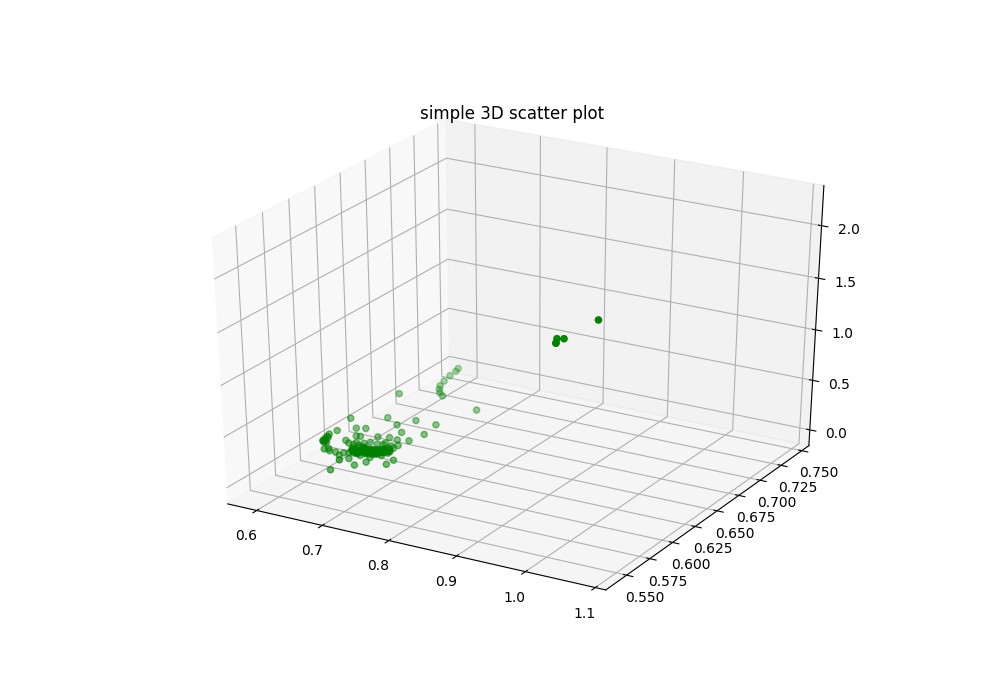

In [29]:
from mpl_toolkits import mplot3d 
import numpy as np 
import matplotlib.pyplot as plt 
  
  
# Creating dataset 
x = [sol.objs[0] for sol in moo_learn.moo_.solutionsList]
y = [sol.objs[1] for sol in moo_learn.moo_.solutionsList]
z = [sol.objs[2] for sol in moo_learn.moo_.solutionsList]
  
# Creating figure 
fig = plt.figure(figsize = (10, 7)) 
ax = plt.axes(projection ="3d") 
  
# Creating plot 
ax.scatter3D(x, y, z, color = "green"); 
plt.title("simple 3D scatter plot") 
  
# show plot 
plt.show() 

In [30]:
pd.DataFrame([sol.objs for sol in moo_learn.moo_.solutionsList])

,0,1,2
0,0.596831,0.676076,0.134585
1,1.079180,0.542666,2.213882
2,0.693147,0.693147,0.000000
3,0.648294,0.589316,0.055201
4,0.590866,0.744048,0.003000
...,...,...,...
145,0.664107,0.613901,0.001083
146,0.660650,0.612675,0.001470
147,0.661582,0.616372,0.000809
148,0.646703,0.608969,0.004704


In [31]:
pd.DataFrame([sol.objs for sol in moo_learn.moo_.solutionsList])

,0,1,2
0,0.596831,0.676076,0.134585
1,1.079180,0.542666,2.213882
2,0.693147,0.693147,0.000000
3,0.648294,0.589316,0.055201
4,0.590866,0.744048,0.003000
...,...,...,...
145,0.664107,0.613901,0.001083
146,0.660650,0.612675,0.001470
147,0.661582,0.616372,0.000809
148,0.646703,0.608969,0.004704
